# Titanic predictions

This project predicts the survival during the titanic disaster based on socio-economic passengers data. The projects features data cleaning, feature engineering, one-hot encoding, feature selection and classifier fitting. The best classifier is Random Forest, with a train accuracy of 0.98 and an F1-score of 0.98. The kaggle submission scores 0.77 on the test set.

## Import packages

In [1]:
import pandas as pd
import csv as csv
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import ConfusionMatrixDisplay

## 1. Load and explore the data

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df  = pd.read_csv("data/test.csv")

Let's look at the data.

In [3]:
display(train_df.head(5))
display(test_df.head(5))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

In [5]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


## 2. Data Cleaning

Let's check for duplicates.

In [7]:
train_df.duplicated().any()

np.False_

In [8]:
test_df.duplicated().any()

np.False_

Check for 0, blank, NaN or None values.

In [9]:
pd.concat([
    (train_df == 0).sum().rename('zeros'),
    (train_df == '').sum().rename('blanks'), 
    train_df.isna().sum().rename('nan'),
    (train_df == None).sum().rename('none')
], axis=1)

,zeros,blanks,nan,none
PassengerId,0,0,0,0
Survived,549,0,0,0
Pclass,0,0,0,0
Name,0,0,0,0
Sex,0,0,0,0
Age,0,0,177,0
SibSp,608,0,0,0
Parch,678,0,0,0
Ticket,0,0,0,0
Fare,15,0,0,0


In [10]:
pd.concat([
    (test_df == 0).sum().rename('zeros'),
    (test_df == '').sum().rename('blanks'), 
    test_df.isna().sum().rename('nan'),
    (test_df == None).sum().rename('none')
], axis=1)

,zeros,blanks,nan,none
PassengerId,0,0,0,0
Pclass,0,0,0,0
Name,0,0,0,0
Sex,0,0,0,0
Age,0,0,86,0
SibSp,283,0,0,0
Parch,324,0,0,0
Ticket,0,0,0,0
Fare,2,0,1,0
Cabin,0,0,327,0


We should replace the missing NaN values in the Age, Fare, Embarked and Cabin column.

## 3. Feature engineering

### 3.1. Create new features from existing ones

Let's create a new column 'Title' by extracting the Title from the 'Name' column using a regular expression. The titles have a space before, end with a . and are composed of letter.

In [11]:
train_df['Title'] = train_df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

There are some redundant titles : Ms, Mlle and Miss are the same and Mme and Mrs are equivalent. Let's combine them.

In [12]:
title_mapping = {'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'}
train_df['Title'] = train_df['Title'].replace(title_mapping)
test_df['Title'] = test_df['Title'].replace(title_mapping)

title normalization : we group rare titles into more common categories based on gender. This helps reducing dimensionality and preventing overfitting. It also handles sparse categories: Titles like 'Dr', 'Rev', 'Col' may have very few examples.

In [13]:
def title_normalization(df):
    """ Group rare title into more common categories"""
    title_mask = ~df['Title'].isin(['Mr', 'Miss', 'Mrs', 'Master'])
    df.loc[title_mask, 'Title'] = df.loc[title_mask, 'Sex'].map({'male': 'Mr', 'female': 'Mrs'})
    return df

train_df = title_normalization(train_df)
test_df = title_normalization(test_df)

Let's extract the deck name from the cabin string. A cabin number looks like ‘C123’. The letter refers to the deck, let's extract these just like the titles using a string pattern. We then fill the remaining NaN values with 'Unkonwn'.

In [14]:
deck_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G']

pattern = '|'.join(deck_list)
train_df['Deck'] = train_df['Cabin'].str.extract(f'({pattern})')
test_df['Deck'] = test_df['Cabin'].str.extract(f'({pattern})')

train_df['Deck'] = train_df['Deck'].fillna('Unknown')
test_df['Deck'] = test_df['Deck'].fillna('Unknown')

Embarked feature: fill missing values by the most common value (mode), which is "S".

In [15]:
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])
test_df['Embarked'] = test_df['Embarked'].fillna(test_df['Embarked'].mode()[0])

Age feature : fill the missing values with the median age, grouped by Title. We also seperate passengers by age groups.

In [16]:
def update_age(df):
    """
    Fill missing age values with median age, grouped by Title.
    Create AgeBand column and convert to int.
    """

    title_age_medians = df.groupby('Title')['Age'].median().to_dict()
    
    for title, median_age in title_age_medians.items():
        age_mask = (df['Age'].isnull()) & (df['Title'] == title)
        df.loc[age_mask, 'Age'] = median_age
    
    df['AgeBand'] = pd.cut(df['Age'], bins=[0, 12, 20, 40, 60, np.inf], labels=[0, 1, 2, 3, 4])
    df['AgeBand'] = df['AgeBand'].astype(int)

    return df

train_df = update_age(train_df)
test_df = update_age(test_df)

Fare feature : fill the missing values with the median fare, and seperate passengers by fare bands.

In [17]:
def update_fare(df):
    """ 
    Fill missing fare values with median fare values.
    Create FareBand column and convert to int.
    """
    
    median_fare = train_df['Fare'].dropna().median()
    train_df['Fare'] = train_df['Fare'].fillna(median_fare)
    test_df['Fare'] = test_df['Fare'].fillna(median_fare)
    
    df['FareBand'] = pd.qcut(df['Fare'], q=4, labels=[0, 1, 2, 3])
    df['FareBand'] = df['FareBand'].astype(int)

    return df

train_df = update_fare(train_df)
test_df = update_fare(test_df)

The fare values are skwed, let's apply a log transform to help with that. Many algorithm assume normally distributed data.

<Axes: >

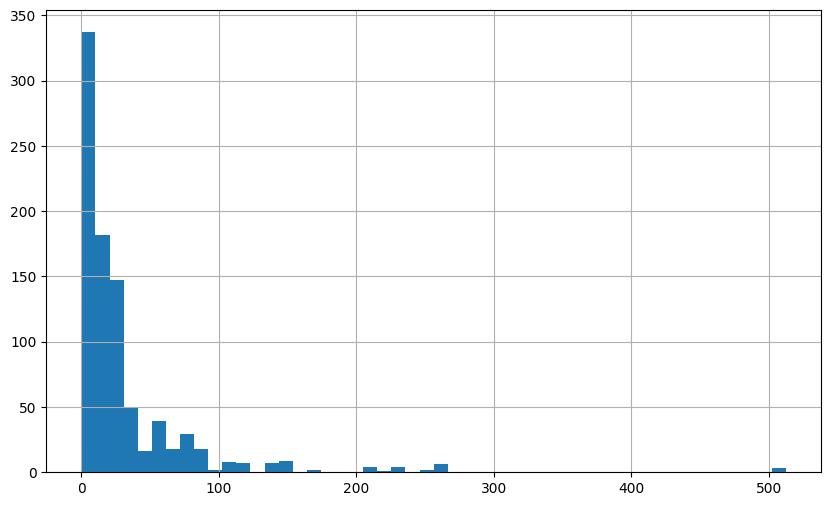

In [18]:
plt.figure(figsize=(10, 6))
train_df['Fare'].hist(bins=50)

In [19]:
train_df['Fare_log'] = np.log1p(train_df['Fare'])
test_df['Fare_log'] = np.log1p(test_df['Fare'])

<Axes: >

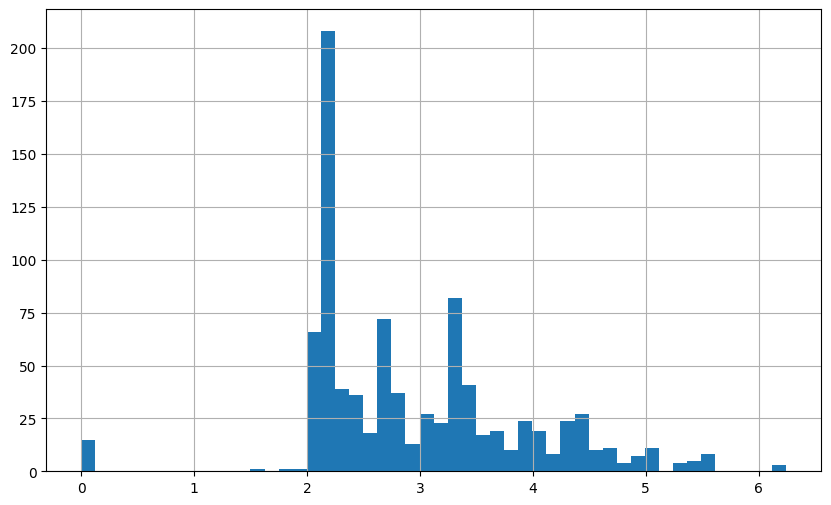

In [20]:
plt.figure(figsize=(10, 6))
train_df['Fare_log'].hist(bins=50)

Let's create a new family size column, as the sum of their ‘SibSp’ and ‘Parch’ attributes. Perhaps people traveling alone did better? Or on the other hand perhaps if you had a family, you might have risked your life looking for them, or even giving up a space up to them in a lifeboat. We also create a column to identify if the person is travelling alone.

In [21]:
train_df['Family_Size'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['Family_Size'] = test_df['SibSp'] + test_df['Parch']

train_df['IsAlone'] = (train_df['Family_Size'] == 1).astype(int)
test_df['IsAlone'] = (test_df['Family_Size'] == 1).astype(int)

Let's create other features.

In [22]:
train_df['Age*Class'] = train_df['Age'] * train_df['Pclass']
test_df['Age*Class'] = test_df['Age'] * test_df['Pclass']

train_df['Age*Fare'] = train_df['Age'] * train_df['Fare'] 
test_df['Age*Fare'] = test_df['Age'] * test_df['Fare']     

train_df['Fare_Per_Person'] = train_df['Fare']/(train_df['Family_Size'] + 1)
test_df['Fare_Per_Person'] = test_df['Fare']/(test_df['Family_Size'] + 1)

### 3.2. Convert categorical features : one-hot encoding
In order to train classifier, we need to convert categorical features into binary numerical features. We are also using drop_first=True to create 1 column instead of 2 for 2 categories (dummy variable trapping). This avoids multicollinearity between columns.

drop_first=False is used for the Title and Deck categories because they don't have a natural baseline/reference category and we want to preserve all information.

In [23]:
def one_hot_encoding(df):
    """ 
    Perform one hot encoding on features Sex, Pclass, Deck, Embarked and Title. 
    Concatenate to the main dataframe.
    """
    df_sex = pd.get_dummies(df['Sex'], prefix='sex', drop_first=True, dtype=int)
    df_Pclass = pd.get_dummies(df['Pclass'], prefix='class', drop_first=True, dtype=int)
    df_Embarked = pd.get_dummies(df['Embarked'], prefix='Embarked', drop_first=True, dtype=int)
    df_Deck = pd.get_dummies(df['Deck'], prefix='Deck', drop_first=False, dtype=int)
    df_Title = pd.get_dummies(df['Title'], prefix='Title', drop_first=False, dtype=int)

    df = pd.concat([df, df_sex, df_Pclass, df_Embarked, df_Deck, df_Title], axis=1)
    return df 
    
train_df = one_hot_encoding(train_df)
test_df = one_hot_encoding(test_df)

In [24]:
(train_df != 0).sum().sort_values(ascending=False)

PassengerId        891
Pclass             891
Name               891
Sex                891
Age                891
Age*Class          891
Ticket             891
Family_Size        891
Cabin              891
Embarked           891
Title              891
Deck               891
Fare_log           876
Fare_Per_Person    876
Age*Fare           876
Fare               876
AgeBand            818
Deck_Unknown       687
FareBand           668
Embarked_S         646
sex_male           577
IsAlone            537
Title_Mr           537
class_3            491
Survived           342
SibSp              283
Parch              213
Title_Miss         185
class_2            184
Title_Mrs          129
Embarked_Q          77
Deck_C              59
Deck_B              47
Title_Master        40
Deck_D              33
Deck_E              32
Deck_A              15
Deck_F              13
Deck_G               4
Deck_T               1
dtype: int64

There are not many counts of Deck_A, Deck_F, Deck_G and Deck_T. We will drop these columns.

### Drop columns
Some columns don't bring useful insights in the prediction, let's drop them. We also save the passenger ID as idx.

In [25]:
idx = test_df['PassengerId'].values
train_df = train_df.set_index('PassengerId')
test_df = test_df.set_index('PassengerId')

train_df = train_df.drop(['Sex', 'Pclass', 'Name', 'Ticket', 'Embarked', 'Cabin', 'Title', 'Fare', 'SibSp', 'Parch', 'Deck', 'Deck_A', 'Deck_F', 'Deck_G', 'Deck_T'], axis=1)
test_df = test_df.drop(['Sex', 'Pclass', 'Name', 'Ticket', 'Embarked', 'Cabin', 'Title', 'Fare', 'SibSp', 'Parch', 'Deck', 'Deck_A', 'Deck_F', 'Deck_G'], axis=1)

In [26]:
pd.concat([
    (train_df == 0).sum().rename('zeros'),
    (train_df == '').sum().rename('blanks'), 
    train_df.isna().sum().rename('nan'),
    (train_df == None).sum().rename('none')
], axis=1)

,zeros,blanks,nan,none
Survived,549,0,0,0
Age,0,0,0,0
AgeBand,73,0,0,0
FareBand,223,0,0,0
Fare_log,15,0,0,0
Family_Size,0,0,0,0
IsAlone,354,0,0,0
Age*Class,0,0,0,0
Age*Fare,15,0,0,0
Fare_Per_Person,15,0,0,0


### Feature Normalisation
This improves distance-based calculations (for KNN, SVM classifiers) and prevents feature dominance.

In [27]:
def scale_features(df):
    """ scale numerical features """
    numeric_columns = ['Age', 'Fare_log', 'Age*Class', 'Age*Fare', 'Fare_Per_Person']
    
    mew = df[numeric_columns].mean(axis=0)
    std = df[numeric_columns].std(axis=0)
    df[numeric_columns] = (df[numeric_columns] - mew) / std

    return df

train_df = scale_features(train_df)
test_df = scale_features(test_df)

Let's look at the cleaned data.

In [28]:
display(train_df.head(5))

,Survived,Age,AgeBand,FareBand,Fare_log,Family_Size,IsAlone,Age*Class,Age*Fare,Fare_Per_Person,...,Embarked_S,Deck_B,Deck_C,Deck_D,Deck_E,Deck_Unknown,Title_Master,Title_Miss,Title_Mr,Title_Mrs
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,-0.556231,2,0,-0.879247,2,0,0.063365,-0.470354,-0.472522,...,1,0,0,0,0,1,0,0,1,0
2,1,0.651050,2,3,1.360456,2,0,-0.786010,0.939063,0.643623,...,0,0,1,0,0,0,0,0,0,1
3,1,-0.254411,2,1,-0.798092,1,1,0.427382,-0.444618,-0.391687,...,1,0,0,0,0,1,0,1,0,0
4,1,0.424685,2,3,1.061442,2,0,-0.877015,0.468975,0.326675,...,1,0,1,0,0,0,0,0,0,1
5,0,0.424685,2,1,-0.783739,1,1,1.246422,-0.402765,-0.388419,...,1,0,0,0,0,1,0,0,1,0


## Fit the model

Let's prepare the data for fitting.

In [29]:
X_train = train_df.iloc[:, 1:] 
X_test = test_df
y_train = train_df.iloc[:, 0]

Define a classification training function.

In [34]:
def classification_model(model, X_train, X_test, y_train):
    """
    Train a classification model and assessing performance
    model: eg. model = LogisticRegression()
    X_train: train dataframe without the target column
    X_test: test dataframe    
    y_train: target column
    """
    
    # Use model class name as model name
    model_name = model.__class__.__name__
    print(f"Training: {model_name}")    
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Perform cross-validation with 5 folds
    scores = cross_val_score(model, X_train, y_train, cv=5)
    cv_mean = np.mean(scores)
    cv_std = np.std(scores)
    
    # Predictions on train set
    y_pred_train = model.predict(X_train)
    
    # Predict on test set 
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    accuracy = metrics.accuracy_score(y_train, y_pred_train)
    precision = metrics.precision_score(y_train, y_pred_train, average='weighted', zero_division=0)
    recall = metrics.recall_score(y_train, y_pred_train, average='weighted', zero_division=0)
    f1 = metrics.f1_score(y_train, y_pred_train, average='weighted', zero_division=0)
    
    # Create results dictionary
    results_dict = {
        'Model_Name': model_name,
        'Train_Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'CV_Mean': cv_mean,
        'CV_Std': cv_std
    }
    
    return y_pred_test, y_pred_train, results_dict

Create a list of classifier.

In [35]:
models = [
    LogisticRegression(),
    RandomForestClassifier(n_estimators=100),
    SVC(),
    GaussianNB(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, metric='minkowski',
   metric_params=None, n_jobs=1, n_neighbors=19, p=2,
   weights='uniform')
]

Train all the models in the list and append results.

In [36]:
results_list = []
result_columns = ['Model_Name', 'Train_Accuracy', 'Precision', 'Recall', 
                    'F1_Score', 'CV_Mean', 'CV_Std']

for model in models:
    _, _, results_dict = classification_model(model, X_train, X_test, y_train)
    results_list.append(results_dict)

results_df = pd.DataFrame(results_list, columns=result_columns)

Training: LogisticRegression
Training: RandomForestClassifier
Training: SVC
Training: GaussianNB
Training: DecisionTreeClassifier
Training: GaussianNB
Training: KNeighborsClassifier


View the results.

In [37]:
results_df.sort_values('Train_Accuracy', ascending=False)

,Model_Name,Train_Accuracy,Precision,Recall,F1_Score,CV_Mean,CV_Std
1,RandomForestClassifier,0.983165,0.983227,0.983165,0.983131,0.829408,0.030255
4,DecisionTreeClassifier,0.983165,0.983291,0.983165,0.983121,0.771082,0.044634
0,LogisticRegression,0.839506,0.838454,0.839506,0.838578,0.831662,0.017643
2,SVC,0.836139,0.835092,0.836139,0.834314,0.833877,0.026826
6,KNeighborsClassifier,0.822671,0.822579,0.822671,0.819067,0.815956,0.019710
3,GaussianNB,0.784512,0.785837,0.784512,0.785074,0.781238,0.056012
5,GaussianNB,0.784512,0.785837,0.784512,0.785074,0.781238,0.056012


The random forest classifier is the best model. Let's fit it again and write the predictions for submission.

In [33]:
def write_output(filename, idx, y_pref):
    """
    Write result of training to filename: 1st column is idx and 2nd column is y_pref
    """        
        
    predictions_file = open(filename, "w")
    open_file_object = csv.writer(predictions_file)
    open_file_object.writerow(["PassengerId", "Survived"])
    open_file_object.writerows(zip(idx, y_pref))
    predictions_file.close()  

In [38]:
model = RandomForestClassifier(n_estimators=100)
y_pred_test, y_pred_train, _ = classification_model(model, X_train, X_test, y_train)
write_output("output/rfc.csv", idx, y_pred_test)

Training: RandomForestClassifier


Let's look at the confusion matrix and classification report.

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       549
           1       0.99      0.97      0.98       342

    accuracy                           0.98       891
   macro avg       0.98      0.98      0.98       891
weighted avg       0.98      0.98      0.98       891



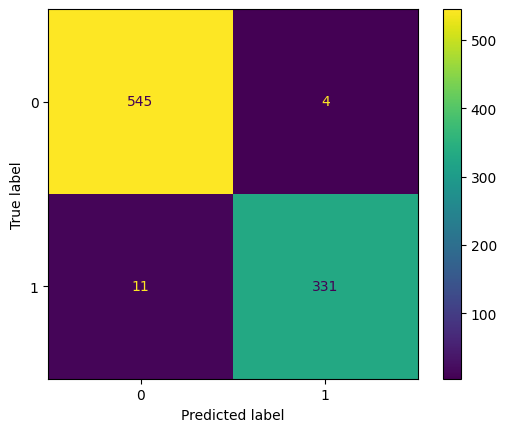

In [39]:
print(metrics.classification_report(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)

### Feature selection
Let's select the 3 most important features by creating a series with feature importances for the random forest classifier.

In [40]:
pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

Age*Class          0.112395
Title_Mr           0.106899
Age*Fare           0.106277
Fare_Per_Person    0.104951
sex_male           0.101946
Fare_log           0.093582
Age                0.080729
Family_Size        0.041619
Title_Mrs          0.040789
class_3            0.039140
Title_Miss         0.038187
Deck_Unknown       0.025679
FareBand           0.021753
Embarked_S         0.017562
AgeBand            0.016637
class_2            0.010291
IsAlone            0.008980
Deck_E             0.007367
Embarked_Q         0.007145
Deck_D             0.005563
Deck_C             0.004942
Title_Master       0.004033
Deck_B             0.003535
dtype: float64

In [42]:
# These are the 3 best features for the random forest classifier.
X_train_best_features = train_df[['Age*Fare', 'Age*Class', 'Title_Mr']]
X_test_best_features = test_df[['Age*Fare', 'Age*Class', 'Title_Mr']]

# Fit the model with only the 3 features
y_pred_test, y_pred_train, _ = classification_model(model, X_train_best_features, X_test_best_features, y_train)
write_output("output/rfc2.csv", idx, y_pred_test)

Training: RandomForestClassifier


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       549
           1       0.98      0.96      0.97       342

    accuracy                           0.98       891
   macro avg       0.98      0.97      0.98       891
weighted avg       0.98      0.98      0.98       891



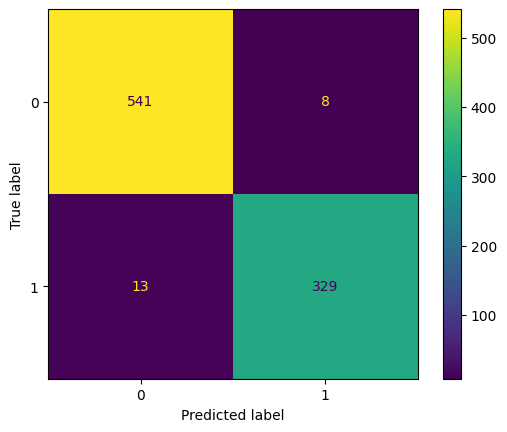

In [43]:
print(metrics.classification_report(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)

The feature selection didn't improve the model.